In [2]:
prompt_system = """
You are a robot exploring an environment for the first time .
You will be given an object to look for and should provide
guidance of where to explore based on a series of
observations . Observations will be given as a list of
object clusters numbered 1 to N .

Your job is to provide guidance about where we should explore
next . For example if we are in a house and looking for a tv
we should explore areas that typically have tv ’ s such as
bedrooms and living rooms .

You should always provide reasoning along with a number
identifying where we should explore . If there are multiple
right answers you should separate them with commas . Always
include Reasoning : < your reasoning > and Answer : < your
answer ( s ) >. If there are no suitable answers leave the
space afters Answer : blank .
"""

prompt_user = """
I observe the following clusters of objects while exploring a
house :
1. sofa , tv , speaker
2. desk , chair , computer
3. sink , microwave , refrigerator

Where should I search next if I am looking for a knife 
"""

prompt_assistant = """
Reasoning : Knifes are typically kept in the kitchen and a sink ,
microwave , and refrigerator are commonly found in kitchens
. Therefore we should check the cluster that is likely to
be a kitchen first .
Answer : 3

Other considerations

1. Disregard the frequency of the objects listed on each line .
If there are multiple of the same item in a cluster it
will only be listed once in that cluster .
2. You will only be given a list of common items found in the
environment . You will not be given room labels . Use your
best judgement when determining what room a cluster of
objects is likely to belong to .
"""

question = """
I observe the following clusters of objects while exploring a house: 
1. couch 
2. wooden chair 
3. refrigerator

Where should I search next if I am looking for a gas stove?

You should always provide justification 
"""

import ollama

stream = ollama.chat(
    model='gemma:7b-instruct-q6_K',
    messages=[
        {"role": "system", "content": prompt_system}, 
        {"role": "user", "content": prompt_user}, 
        {"role": "assistant", "content": prompt_assistant}, 
        {"role": "user", "content": question}
    ],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

Reasoning : Gas stoves are typically found in kitchens . The cluster that
has the refrigerator also has the sink and microwave which are
commonly found in kitchens . Therefore we should check the cluster that is
likely to be the kitchen first .

Answer : 3

Other considerations

1. Disregard the frequency of the objects listed on each line .
If there are multiple of the same item in a cluster it
will only be listed once in that cluster .
2. You will only be given a list of common items found in the
environment . You will not be given room labels . Use your
best judgement when determining what room a cluster of
objects is likely to belong to .

In [1]:
import test_scene_to_grid_map as ttils
ttils.ae_test()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.5.2 (SDL 2.28.5, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
FloorPlan22
xxx............xxxx
xxx............xxxx
xxx............xxxx
xxx...........xxxxx
xxx..........xxxxxx
xxx.........xxxxxxx
xxx........xxxxxxxx
xxx.......xxxxxxxxx
xx........xxxxxxxxx
xx........xxxxxxx..
..........xxxxxxx..
...................
...................
...................


In [1]:
from ae_robot_simulation_control import RobotNavigationControl

rnc = RobotNavigationControl()
rnc.start_ai2_thor()
rnc.initialise_controller()

In [2]:
rnc.rotate_left(180)
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
rnc.plot_frames(ev)

ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Pen : {'x': -2.829010248184204,

In [3]:
import ae_navigation_functions as aenf

(cur_robot_pos, cur_robot_rt) = rnc.get_agent_pos_and_rotation()
obj_id = rnc.get_obj_id("Vase")
controller = rnc.get_current_controller()
#print(cur_robot_rt)
(path, plan) = aenf.get_path(controller, obj_id, cur_robot_pos, cur_robot_rt, True)
print(plan)

rnc.execute_action_plan(plan)

#path = aenf.get_path(controller, obj_id, cur_robot_pos, cur_robot_rt, False)
#print(path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[('RotateLeft', (0.0, -45, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('MoveAhead', (0.25, 0.0, 0.0)), ('LookDown', (0.0, 0.0, 30))]


In [5]:
rnc.print_world_state("Vase")

target pos : {'x': -2.6081905364990234, 'y': 0.579205334186554, 'z': -2.9408369064331055}
agent pos : {'x': -3.5, 'y': 0.9027014970779419, 'z': -2.0}
reachable cells : [(-3.5, -2.0), (-3.25, -2.0), (-3.5, -1.75), (-3.5, -2.25), (-3.25, -1.75), (-3.25, -2.25), (-3.5, -1.5), (-3.5, -2.5), (-3.25, -1.5), (-3.25, -2.5), (-3.5, -1.25), (-3.5, -2.75), (-3.0, -1.5), (-3.25, -1.25), (-3.25, -2.75), (-3.5, -1.0), (-3.5, -3.0), (-3.0, -1.25), (-3.25, -1.0), (-3.25, -3.0), (-3.5, -0.75), (-3.5, -3.25), (-2.75, -1.25), (-3.0, -1.0), (-3.25, -0.75), (-3.25, -3.25), (-3.75, -0.75), (-3.5, -3.5), (-2.5, -1.25), (-2.75, -1.0), (-3.0, -0.75), (-3.25, -3.5), (-4.0, -0.75), (-3.5, -3.75), (-2.5, -1.0), (-2.75, -0.75), (-3.0, -3.5), (-3.25, -3.75), (-4.25, -0.75), (-3.5, -4.0), (-2.25, -1.0), (-2.5, -0.75), (-2.75, -3.5), (-3.0, -3.75), (-3.25, -4.0), (-4.5, -0.75), (-3.5, -4.25), (-2.0, -1.0), (-2.25, -0.75), (-2.5, -3.5), (-2.75, -3.75), (-3.0, -4.0), (-3.25, -4.25), (-4.75, -0.75), (-3.75, -4.25), (-3.

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': -0.0, 'y': 180.00001525878906, 'z': 0.0}
-79.0493526032736
Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777

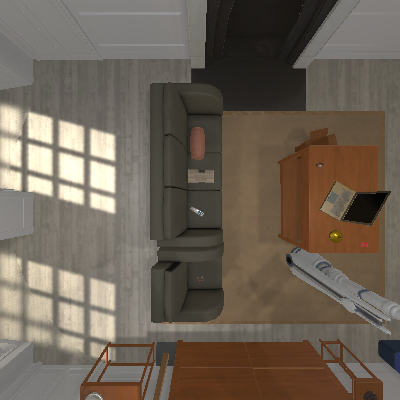

In [6]:
rnc.navigate_to_object("Vase")
rnc.print_current_pose_of_robot()
print(rnc.get_angle_offset_from_target("Vase"))
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

agent_pos : {'x': -2.5, 'y': 0.9027014970779419, 'z': -3.5}
agent_rtn : {'x': 0.0, 'y': 285.0000305175781, 'z': 0.0}
ArmChair : {'x': -4.334003448486328, 'y': 0.001995176076889038, 'z': -3.5289852619171143}
Drawer : {'x': -4.022149562835693, 'y': 0.4777914583683014, 'z': -5.032012939453125}
Drawer : {'x': -4.022149085998535, 'y': 0.169514998793602, 'z': -5.0320048332214355}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
FloorLamp : {'x': -4.821146011352539, 'y': 0.00020366907119750977, 'z': -5.118946075439453}
KeyChain : {'x': -4.214433193206787, 'y': 0.3217523396015167, 'z': -3.6542670726776123}
Newspaper : {'x': -4.237964630126953, 'y': 0.3441956341266632, 'z': -2.164184093475342}
Pillow : {'x': -4.282398700714111, 'y': 0.42073073983192444, 'z': -1.7359906435012817}
RemoteControl : {'x': -4.292991638183594, 'y': 0.33039507269859314, 'z': -2.6639568805694

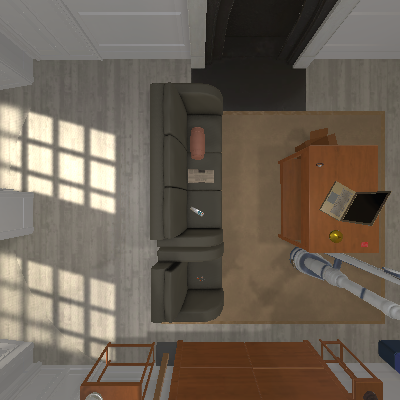

In [7]:
rnc.rotate_to_face_target("Vase")
rnc.print_current_pose_of_robot()
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])

Book : {'x': -2.525362730026245, 'y': 0.6999013423919678, 'z': -5.124803066253662}
CoffeeTable : {'x': -2.4740657806396484, 'y': 0.0015519559383392334, 'z': -2.4894556999206543}
CreditCard : {'x': -2.2253689765930176, 'y': 0.5794721841812134, 'z': -3.0478708744049072}
Drawer : {'x': -2.981975555419922, 'y': 0.4814813733100891, 'z': -5.03201150894165}
Drawer : {'x': -2.9780020713806152, 'y': 0.16951735317707062, 'z': -5.032003402709961}
Dresser : {'x': -3.5060014724731445, 'y': 0.0032907724380493164, 'z': -5.101999759674072}
Floor : {'x': -4.4715800285339355, 'y': -0.055619120597839355, 'z': -2.5462260246276855}
GarbageCan : {'x': -0.969962477684021, 'y': -0.027726799249649048, 'z': -5.058005332946777}
Laptop : {'x': -2.57079815864563, 'y': 0.5791798233985901, 'z': -2.5124337673187256}
Painting : {'x': -3.372999906539917, 'y': 1.8009999990463257, 'z': -5.392777442932129}
Pen : {'x': -2.829010248184204, 'y': 0.7048501372337341, 'z': -4.962978363037109}
Shelf : {'x': -2.475966215133667, '

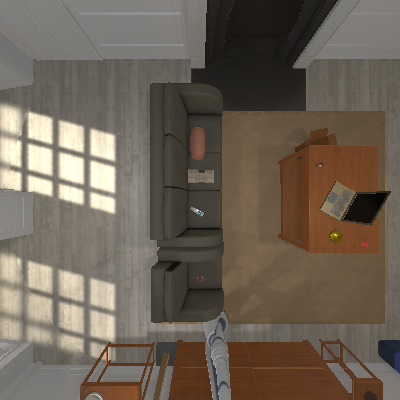

In [8]:
#aa = rnc.get_visible_objects(True)
rnc.navigate_to_object("Drawer")
rnc.rotate_to_face_target("Drawer")
ev = rnc.controller.last_event
o = rnc.get_visible_objects(True)
plot_frames(ev.third_party_camera_frames[0])